## Methods of SIR Estimation   
The application of individual for a given SIR threshold necessitates an estimate of the SIR. 


In [183]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

# Load all CSV files into a pandas DataFrame
data_list = []
csv_dir = os.path.abspath('output/20241127-091932/csv')
for filename in os.listdir(csv_dir):
    if filename.endswith(".csv") and filename.startswith('snr'):
        try:
            parts = filename.split('_')
            sir_val = float(parts[1])
            symbol_value = int(parts[3])
            rate = float(parts[5].removesuffix(".csv"))
        except ValueError:
            print(f"Invalid filename {filename}. Expected format: snr_{sir_val}_symbol_{symbol_value}_rate{rate}.csv")
            continue

        # Read the CSV file into a pandas DataFrame
        file_path = os.path.join(csv_dir, filename)
        data = pd.read_csv(file_path, header=None)

        # create a new column for SNR and Symbol as labels
        data['rate'] = rate
        data['snr'] = sir_val
        data['symbol'] = symbol_value
        data_list.append(data)
    
# Concatenate dataframes
fft_data = pd.concat(data_list, ignore_index=True)
fft_data.rename(columns={0: "freqs"}, inplace=True)
fft_data['freqs'] = fft_data['freqs'].apply(lambda x: list(map(float, x.split(';'))))

# Sort data by SIR
fft_data.sort_values(by=['rate','snr','symbol'], ascending=True, inplace=True)

# Convert to power
fft_data['power'] = fft_data['freqs'].apply(lambda x: abs(np.array(x))**2)


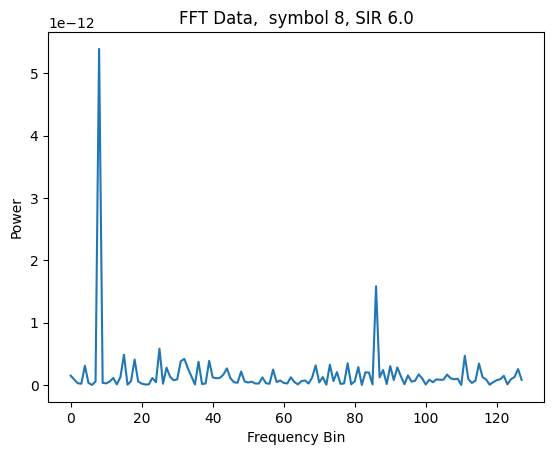

In [184]:
# Plot the last fft data in the dataframe
symbol_data = fft_data.iloc[8*10*129]
plt.plot(symbol_data['power'])
plt.title(f'FFT Data,  symbol {symbol_data['symbol']}, SIR {symbol_data["snr"]}')
plt.xlabel('Frequency Bin')
plt.ylabel('Power')
plt.show()

### Sum of remaining FFT bins
Knowing the receiver noise 

In [203]:
from scipy.signal import find_peaks

fft_pow = symbol_data['power']

# Sort the array in descending order and take the top three values
peaks = np.sort(fft_pow)[-3:][::-1]



sir = 10*np.log10(peaks[0]/peaks[1])
print(sir)

5.322237080005915


In [ ]:




# Calculate the noise floor
k = 1.38e-23
T = 298.16
BW = 250e3
noise_floor = (k * T * BW) / 128

sampling_rate = 250e3
fft_bins = 128  
bin_bandwidth = sampling_rate / fft_bins
noise_floor_est = np.mean(fft_pow[80:110]) # Noise per bin
scaled_noise_floor = noise_floor_est * (BW / bin_bandwidth)

fft_pow = fft_pow - noise_floor

signal_power = np.max(fft_pow)
interf_pow = np.sum(fft_pow) - signal_power
print(f"SIR: {10*np.log10(signal_power / interf_pow):.2f} dB")

# Calculate the SNR
